In [12]:
from googleapiclient.discovery import build
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
from stop_words import get_stop_words
import time
import html

In [4]:
API_KEY = 'masking api key'
REGION = "UA"
MAX_CHANNELS = 20
VIDEOS_PER_CHANNEL = 200
FONT_PATH = "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"  # Windows: "C:\\Windows\\Fonts\\arial.ttf"

youtube = build("youtube", "v3", developerKey=API_KEY)

uk_stopwords = set(get_stop_words("uk"))
en_stopwords = set(get_stop_words("en"))
ru_stopwords = set(get_stop_words("ru"))
all_stopwords = uk_stopwords.union(en_stopwords).union(ru_stopwords)

def preprocess_text(text):
    text = html.unescape(text)
    text = text.lower()
    text = re.sub(r"http\S+", "", text)

    # Залишимо хештеги
    exclude = set(string.punctuation) - {"#"}
    text = ''.join(ch for ch in text if ch not in exclude)

    tokens = text.split()
    tokens = [word for word in tokens if word not in all_stopwords]
    return " ".join(tokens)

def get_trending_channels(region=REGION, max_results=MAX_CHANNELS):
    trending = youtube.videos().list(
        part="snippet",
        chart="mostPopular",
        regionCode=region,
        maxResults=max_results
    ).execute()

    channels = {}
    for item in trending["items"]:
        cid = item["snippet"]["channelId"]
        channels[cid] = item["snippet"]["channelTitle"]
    return channels

def get_channel_videos(channel_id, max_total=VIDEOS_PER_CHANNEL):
    all_videos = []
    next_page = None

    while len(all_videos) < max_total:
        resp = youtube.search().list(
            part="snippet",
            channelId=channel_id,
            order="date",
            maxResults=50,
            pageToken=next_page,
            type="video"
        ).execute()

        for item in resp["items"]:
            all_videos.append({
                "channelId": channel_id,
                "channelTitle": item["snippet"]["channelTitle"],
                "videoTitle": item["snippet"]["title"],
                "videoId": item["id"]["videoId"],
                "publishedAt": item["snippet"]["publishedAt"]
            })

        next_page = resp.get("nextPageToken")
        if not next_page:
            break
        time.sleep(1)  # Prevent rate limit

    return all_videos[:max_total]

channels = get_trending_channels()
all_data = []

for cid, cname in channels.items():
    print(f"Fetching videos from: {cname}")
    vids = get_channel_videos(cid)
    all_data.extend(vids)

df = pd.DataFrame(all_data)

Fetching videos from: Суспільне Запоріжжя
Fetching videos from: ТСН
Fetching videos from: Никита ЗАРАЗ
Fetching videos from: BATEK_OFFICIAL
Fetching videos from: Руслан Гладенко
Fetching videos from: Сергей Милушкин
Fetching videos from: Reel Cinema
Fetching videos from: Twi Shorts
Fetching videos from: Sergio Nee
Fetching videos from: ТНТ - шоу
Fetching videos from: Суспільне Івано-Франківськ
Fetching videos from: RCDriftTok
Fetching videos from: CRAZY GREAPA
Fetching videos from: Carter Sharer
Fetching videos from: RainBow
Fetching videos from: БЕРТ
Fetching videos from: Поле брани
Fetching videos from: История одного вокалиста
Fetching videos from: Загін Кіноманів


In [5]:
df.to_csv("youtube_video_data_backup.csv", index=False)

In [ ]:
import os

BACKUP_FILE = "youtube_video_data_backup.csv"

if os.path.exists(BACKUP_FILE):
    print("Loading dataset from backup...")
    df = pd.read_csv(BACKUP_FILE)

In [6]:
df

,channelId,channelTitle,videoTitle,videoId,publishedAt
0,UCZSashx8dRHivfiJuim_OHg,Суспільне Запоріжжя,&quot;Під грубу печі сховалися і таким чином в...,RSYfuhyn57U,2025-06-01T15:39:50Z
1,UCZSashx8dRHivfiJuim_OHg,Суспільне Запоріжжя,"&quot;Я досі пам’ятаю день, коли російська бом...",n-MGOzWR4Ow,2025-06-01T13:01:17Z
2,UCZSashx8dRHivfiJuim_OHg,Суспільне Запоріжжя,&quot;Співвідношення сил були десять до одного...,vhRX6ZnRd7U,2025-06-01T11:01:32Z
3,UCZSashx8dRHivfiJuim_OHg,Суспільне Запоріжжя,"&quot;Думаєш як там діти, до них не прилетіла ...",wGYDfFFe8vo,2025-06-01T09:01:22Z
4,UCZSashx8dRHivfiJuim_OHg,Суспільне Запоріжжя,Армія РФ атакувала дронами Запоріжжя: є поранена,oqk-9qtGEDU,2025-06-01T07:16:13Z
...,...,...,...,...,...
2596,UCig7t6LFOjS2fKkhjbVLpjw,Загін Кіноманів,"ПАВЛО СКОРОХОДЬКО - ГОЛОС СІДА, ГАРРІ ПОТТЕРА⚡...",KiQ2dJSIiFo,2021-03-11T16:00:06Z
2597,UCig7t6LFOjS2fKkhjbVLpjw,Загін Кіноманів,ЗАРУБІЖНІ ФІЛЬМИ ЗНЯТІ В УКРАЇНІ!🤩 ПЕРЕВІЗНИК ...,XBCHOS3gSiQ,2021-02-28T16:47:26Z
2598,UCig7t6LFOjS2fKkhjbVLpjw,Загін Кіноманів,ЛЮБОМИР ЛЕВИЦЬКИЙ - ІНТЕРВ&#39;Ю ПРО СКАЖЕНЕ В...,0f112MWJJzc,2021-02-21T17:30:03Z
2599,UCig7t6LFOjS2fKkhjbVLpjw,Загін Кіноманів,ЩО ТРАПИЛОСЬ З РЕСЛЕРАМИ З QTV (КУЙ ТБ)?,j01paByxH44,2021-02-13T16:04:28Z


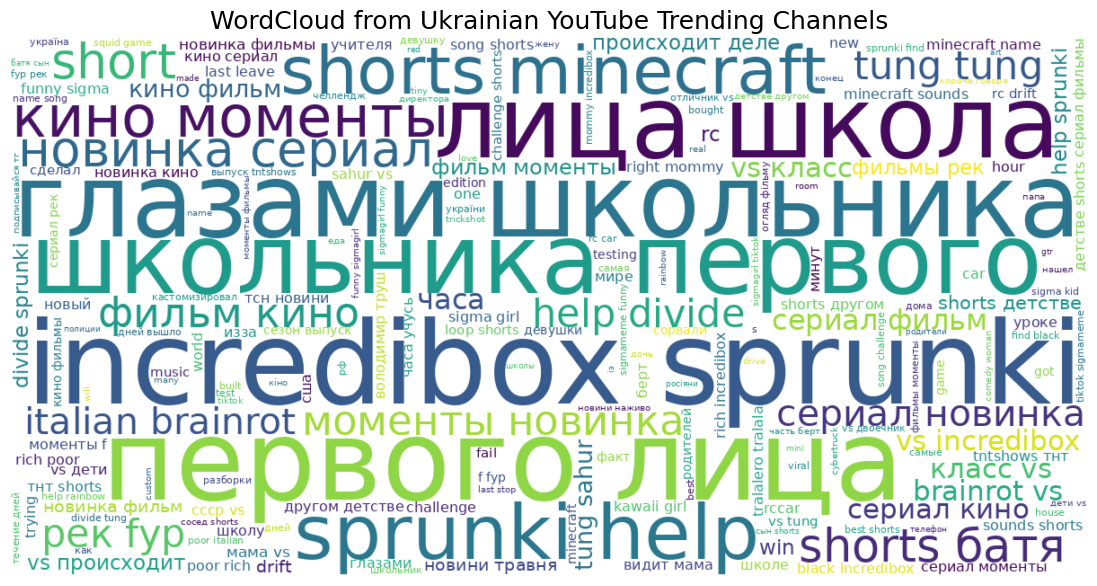

In [13]:
df["cleanTitle"] = df["videoTitle"].apply(preprocess_text)

all_text = " ".join(df["cleanTitle"])
wordcloud = WordCloud(
    width=1200,
    height=600,
    background_color="white",
    font_path=FONT_PATH
).generate(all_text)

plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud from Ukrainian YouTube Trending Channels", fontsize=18)
plt.show()

In [14]:
df

,channelId,channelTitle,videoTitle,videoId,publishedAt,cleanTitle
0,UCZSashx8dRHivfiJuim_OHg,Суспільне Запоріжжя,&quot;Під грубу печі сховалися і таким чином в...,RSYfuhyn57U,2025-06-01T15:39:50Z,грубу печі сховалися таким чином вціліли очеви...
1,UCZSashx8dRHivfiJuim_OHg,Суспільне Запоріжжя,"&quot;Я досі пам’ятаю день, коли російська бом...",n-MGOzWR4Ow,2025-06-01T13:01:17Z,досі пам’ятаю російська бомба влучила будинок ...
2,UCZSashx8dRHivfiJuim_OHg,Суспільне Запоріжжя,&quot;Співвідношення сил були десять до одного...,vhRX6ZnRd7U,2025-06-01T11:01:32Z,співвідношення сил штурм позицій старомайорському
3,UCZSashx8dRHivfiJuim_OHg,Суспільне Запоріжжя,"&quot;Думаєш як там діти, до них не прилетіла ...",wGYDfFFe8vo,2025-06-01T09:01:22Z,думаєш діти прилетіла ракета прилетіла
4,UCZSashx8dRHivfiJuim_OHg,Суспільне Запоріжжя,Армія РФ атакувала дронами Запоріжжя: є поранена,oqk-9qtGEDU,2025-06-01T07:16:13Z,армія рф атакувала дронами запоріжжя поранена
...,...,...,...,...,...,...
2596,UCig7t6LFOjS2fKkhjbVLpjw,Загін Кіноманів,"ПАВЛО СКОРОХОДЬКО - ГОЛОС СІДА, ГАРРІ ПОТТЕРА⚡...",KiQ2dJSIiFo,2021-03-11T16:00:06Z,павло скороходько голос сіда гаррі поттера⚡️ т...
2597,UCig7t6LFOjS2fKkhjbVLpjw,Загін Кіноманів,ЗАРУБІЖНІ ФІЛЬМИ ЗНЯТІ В УКРАЇНІ!🤩 ПЕРЕВІЗНИК ...,XBCHOS3gSiQ,2021-02-28T16:47:26Z,зарубіжні фільми зняті україні🤩 перевізник 3 с...
2598,UCig7t6LFOjS2fKkhjbVLpjw,Загін Кіноманів,ЛЮБОМИР ЛЕВИЦЬКИЙ - ІНТЕРВ&#39;Ю ПРО СКАЖЕНЕ В...,0f112MWJJzc,2021-02-21T17:30:03Z,любомир левицький інтервю скажене весілля 3 ка...
2599,UCig7t6LFOjS2fKkhjbVLpjw,Загін Кіноманів,ЩО ТРАПИЛОСЬ З РЕСЛЕРАМИ З QTV (КУЙ ТБ)?,j01paByxH44,2021-02-13T16:04:28Z,трапилось реслерами qtv куй тб


### Препроцесинг завершено